[![CyVers](https://i.imgur.com/yyhmZET.png)](https://www.cyvers.ai/)

# BlockChain Attack Data Set - Exploratory Data Analysis (EDA)

> Notebook by:
> - Royi Avital Royi@cyvers.ai

## Revision History

| Version | Date       | User        |Content / Changes                                                   |
|---------|------------|-------------|--------------------------------------------------------------------|
| 0.1.000 | 30/06/2022 | Royi Avital | First version                                                      |
| 0.2.000 | 25/07/2022 | Royi Avital | Added model selection and visualization of features                |
| 0.3.000 | 31/07/2022 | Royi Avital | Added a view of feature importance (Should be moved to a funciton) |
|         |            |             |                                                                    |

In [1]:
# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Misc
import datetime
import os
from platform import python_version
import random
import warnings

# EDA Tools
import ppscore as pps #<! See https://github.com/8080labs/ppscore -> pip install git+https://github.com/8080labs/ppscore.git

# Machine Learning
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
# from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import confusion_matrix, fbeta_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedGroupKFold, train_test_split

# Ensemble Engines
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from bokeh.plotting import figure, show

# Jupyter
from ipywidgets import interact, Dropdown, Layout

In [2]:
# Configuration
%matplotlib inline

warnings.filterwarnings("ignore")

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

sns.set_theme() #>! Apply SeaBorn theme

In [3]:
# Constants

DATA_FOLDER_NAME    = 'BlockChainAttacksDataSet'
DATA_FOLDER_PATTERN = 'DataSet0'
DATA_FILE_EXT       = 'csv'

PROJECT_DIR_NAME = 'CyVers' #<! Royi: Anton, don't change it, it should be a team constant
PROJECT_DIR_PATH = os.path.join(os.getcwd()[:os.getcwd().find(PROJECT_DIR_NAME)], PROJECT_DIR_NAME) #>! Pay attention, it will create issues in cases you name the folder `CyVersMe` or anything after / before `CyVers`

# Feature extractors constants

TRAIN_BY_TSX    = 1
TRAIN_BY_FILES  = 2

In [4]:
# CyVers Packages
from DataSetsAuxFun import *

In [5]:
# Parameters
dataSetRotoDir = os.path.join(PROJECT_DIR_PATH, DATA_FOLDER_NAME)

# Features Analysis
numCrossValPps = 4

# Training
trainMode = TRAIN_BY_FILES
testSetRatio = 1 / 3
numKFolds = 3
gridSearchScore = 'f1' #<! Use strings from `sklearn.metrics.get_scorer_names()`
gridSearchScore = 'recall' #<! We need to have better PD

# Amount USD Outlier threshold
amountUsdOutlierThr = 1e9

randomState = 42

lSlctedFeaturesRaw    = ['Amount', 'Currency', 'Currency Type', 'Amount [USD]', 'Receiver Type', 'Gas Price', 'Gas Limit', 'Gas Used' ]#lSlctedFeaturesRaw    = ['Amount', 'Currency', 'Amount [USD]', 'Receiver Type']
lSlctedFeaturesCalc   = [enumObj.name for enumObj in FeatureName if ((enumObj is not FeatureName.TIME_MAX) and (enumObj is not FeatureName.TIME_MIN))]
lSlctdFeatures        = lSlctedFeaturesRaw + lSlctedFeaturesCalc
lCatFeatures          = ['Currency', 'Currency Type', 'Receiver Type']#lCatFeatures          = ['Currency', 'Receiver Type']
# lFeaturesRemove       = [FeatureName.TIME_MAX.name, FeatureName.TIME_MIN.name] #<! Auxiliary features to be removed before processing

timeColStr = 'Block Time'

In [6]:
# Loading / Generating Data
lCsvFile = ExtractCsvFiles(dataSetRotoDir, folderNamePattern = DATA_FOLDER_PATTERN)
print(f'The number of file found: {len(lCsvFile)}')

# dfData = pd.read_csv(os.path.join(DATA_FOLDER_NAME, csvFileName))
dfData, dAssetFile = LoadCsvFilesDf(lCsvFile, baseFoldePath = '')
numRows, numCols = dfData.shape

print(f"The number of rows (Samples): {numRows}, The number of columns: {numCols}, number of unique sender id's: {dfData['Sender ID'].unique().shape}")
print(f'The data list of columns is: {dfData.columns} with {len(dfData.columns)} columns')

The number of file found: 249
The number of rows (Samples): 1713729, The number of columns: 19, number of unique sender id's: (249,)
The data list of columns is: Index(['Transaction ID', 'Transaction Time', 'Block Time', 'Sender ID',
       'Receiver ID', 'Receiver Type', 'Amount', 'Currency', 'Currency Hash',
       'Currency Type', 'Amount [USD]', 'Gas Price', 'Gas Limit', 'Gas Used',
       'Gas Predicted', 'Balance In', 'Balance Out', 'Label', 'Risk Level'],
      dtype='object') with 19 columns


In [7]:
# Convert time data into Pandas format
dfData[timeColStr] = pd.to_datetime(dfData[timeColStr], infer_datetime_format = 'True') #<! Stable time format

In [8]:
# Sort data by transaction date
dfData.sort_values(timeColStr, inplace = True)
# dfData.reset_index(drop = True, inplace = True)

In [9]:
# Meet the data
dfData.head(20)

,Transaction ID,Transaction Time,Block Time,Sender ID,Receiver ID,Receiver Type,Amount,Currency,Currency Hash,Currency Type,Amount [USD],Gas Price,Gas Limit,Gas Used,Gas Predicted,Balance In,Balance Out,Label,Risk Level
828630,0x2971c7bcbf18c57a2879b07a0f6dbbc14b7c928a0335...,NaN,2016-02-12 11:01:25+00:00,0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c,0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c,Wallet,0.500000,ETH,0x0000000000000000000000000000000000000000,NaN,2.737825,5.000000e-08,121000.0,21000,NaN,NaN,NaN,0,NaN
828629,0xc18b50d6311d2de6f6bfd450a38291297eb0e1c96320...,NaN,2016-05-11 09:23:12+00:00,0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c,0xbb9bc244d798123fde783fcc1c72d3bb8c189413,Token,50.000000,ETH,0x0000000000000000000000000000000000000000,NaN,499.065146,3.221000e-08,174091.0,74091,NaN,NaN,NaN,0,NaN
828628,0x29d0b83aeead81925d6df3a5c252bb759811fbc5bb5d...,NaN,2016-05-13 11:44:02+00:00,0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c,0x335195726ba56b51cbd5d569c0aa5ccf5c1f4e28,Wallet,26.000000,ETH,0x0000000000000000000000000000000000000000,NaN,275.227201,3.221000e-08,121000.0,21000,NaN,NaN,NaN,0,NaN
828627,0x292d05383a2d9150c5b24718ceef760608561469222f...,NaN,2016-05-19 07:50:40+00:00,0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c,0x335195726ba56b51cbd5d569c0aa5ccf5c1f4e28,Wallet,50.000000,ETH,0x0000000000000000000000000000000000000000,NaN,735.916238,2.000000e-08,121000.0,21000,NaN,NaN,NaN,0,NaN
828626,0x4020de95411dd43e8613588f07a8e9643093c8e9c9a2...,NaN,2016-05-20 12:29:30+00:00,0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c,0x335195726ba56b51cbd5d569c0aa5ccf5c1f4e28,Wallet,100.000000,ETH,0x0000000000000000000000000000000000000000,NaN,1369.368343,2.000000e-08,121000.0,21000,NaN,NaN,NaN,0,NaN
828625,0xde1fb69bc6f78d32413ef8cc800ee4379855636c8daa...,NaN,2016-07-20 13:30:33+00:00,0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c,0xbf4ed7b27f1d666546e30d74d50d173d20bca754,Smart Contract,5000.000000,DAO,0xbb9bc244d798123fde783fcc1c72d3bb8c189413,ERC20,NaN,2.000000e-08,158971.0,43971,NaN,NaN,NaN,0,NaN
828624,0xfb4686f9c20f25573ad8e0b67b4dca472270a49f5e47...,NaN,2016-08-28 15:26:36+00:00,0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c,0x51f4d62b7444f058aba634f9ec43590a9cd768a3,Wallet,8.572152,DGD,0xe0b7927c4af23765cb51314a0e0521a9645f0e2a,ERC20,88.207441,3.221000e-08,150245.0,36525,NaN,NaN,NaN,0,NaN
828623,0x14dbc5b173174d831285b69676dcb6bbb7cd1f3b4e11...,NaN,2016-09-25 17:06:46+00:00,0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c,0x755cdba6ae4f479f7164792b318b2a06c759833b,Smart Contract,0.000000,-,-,-,NaN,3.100000e-08,100000.0,40655,NaN,NaN,NaN,0,NaN
828622,0x517c5c9eb46465df40d79946ae8c369a9efcf26b68de...,NaN,2016-09-26 00:00:53+00:00,0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c,0xaf30d2a7e90d7dc361c8c4585e9bb7d2f6f15bc7,Token,25.000000,ETH,0x0000000000000000000000000000000000000000,NaN,320.468660,3.300000e-08,300000.0,72056,NaN,NaN,NaN,0,NaN
828621,0xc1bb43777ef943f1e5f80f7d16967f8858049bb3052e...,NaN,2016-10-01 19:48:52+00:00,0x537bf75de19f3d229e3a9018ee1a23c0c9c7d39c,0x94d9620d4b33b08922f12ddfb15c8d8b08597f5b,Wallet,5.000000,ETH,0x0000000000000000000000000000000000000000,NaN,66.349136,2.300000e-08,21000.0,21000,NaN,NaN,NaN,0,NaN


# Information about the Data Before Pre Processing

1. See the labeled cases.
2. Count the Labels data.
3. Number of unique assets.
4. Pandas' `info()` and `describe()`.

After this phase, the data is _read only_.

In [10]:
# Look at attack cases
dfData.loc[dfData['Label'] == 1, :]

,Transaction ID,Transaction Time,Block Time,Sender ID,Receiver ID,Receiver Type,Amount,Currency,Currency Hash,Currency Type,Amount [USD],Gas Price,Gas Limit,Gas Used,Gas Predicted,Balance In,Balance Out,Label,Risk Level
1712707,0x0e0d16475d2ac6a4802437a35a21776e5c9b681a77fe...,NaN,2017-07-18 22:33:23+00:00,0x91efffb9c6cd3a66474688d0a48aa6ecfe515aa5,0xb3764761e297d6f121e79c32a65829cd1ddb4d32,Wallet,26793.000000,ETH,0x0000000000000000000000000000000000000000,NaN,6.122288e+06,2.100000e-08,162754.0,60001,NaN,NaN,NaN,1,NaN
1712679,0x97f7662322d56e1c54bd1bab39bccf98bc736fcb9c7e...,NaN,2017-07-19 12:14:18+00:00,0x50126e8fcb9be29f83c6bbd913cc85b40eaf86fc,0xb3764761e297d6f121e79c32a65829cd1ddb4d32,Wallet,44055.000000,ETH,0x0000000000000000000000000000000000000000,NaN,8.792960e+06,2.100000e-08,88926.0,58433,NaN,NaN,NaN,1,NaN
1712719,0xeef10fc5170f669b86c4cd0444882a96087221325f8b...,NaN,2017-07-19 12:19:36+00:00,0xbec591de75b8699a3ba52f073428822d0bfc0d7e,0xb3764761e297d6f121e79c32a65829cd1ddb4d32,Wallet,82189.000000,ETH,0x0000000000000000000000000000000000000000,NaN,1.640414e+07,2.100000e-08,78926.0,58433,NaN,NaN,NaN,1,NaN
1710588,0x283fd14161d9841571acdc4b629de597bfdcdd197647...,NaN,2017-08-21 05:11:33+00:00,0xa95842e41380100c12caf7b872baa77ce6d8ad24,0x29d7d1dd5b6f9c864d9db560d72a247c178ae86b,Wallet,10.000000,ETH,0x0000000000000000000000000000000000000000,NaN,3.222012e+03,2.287500e-08,25201.0,21000,NaN,NaN,NaN,1,NaN
1710587,0xa22dafd9184d9eb54deb021d2467eb4e4aee84aee121...,NaN,2017-08-21 05:18:32+00:00,0xa95842e41380100c12caf7b872baa77ce6d8ad24,0x29d7d1dd5b6f9c864d9db560d72a247c178ae86b,Wallet,7.000000,ETH,0x0000000000000000000000000000000000000000,NaN,2.255409e+03,2.404531e-08,25201.0,21000,NaN,NaN,NaN,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1682544,0x96eaed8d878ff739c1f293b53a073b2dfefbdf762854...,NaN,2022-07-11 20:47:54+00:00,0xc36442b4a4522e871399cd717abdd847ab11fe88,0x09b5027ef3a3b7332ee90321e558bad9c4447afa,Wallet,0.354521,WBTC,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,ERC20,7.038288e+03,3.026881e-08,300997.0,186985,NaN,NaN,NaN,1,NaN
1682543,0x232e6cbe6b382019c237ebf913979105870aa6221fe1...,NaN,2022-07-11 20:48:17+00:00,0xc36442b4a4522e871399cd717abdd847ab11fe88,0x09b5027ef3a3b7332ee90321e558bad9c4447afa,Wallet,2389.581778,ETH,0x0000000000000000000000000000000000000000,NaN,2.793451e+06,2.663459e-08,343816.0,229212,NaN,NaN,NaN,1,NaN
1682541,0x232e6cbe6b382019c237ebf913979105870aa6221fe1...,NaN,2022-07-11 20:48:17+00:00,0xc36442b4a4522e871399cd717abdd847ab11fe88,0x09b5027ef3a3b7332ee90321e558bad9c4447afa,Wallet,198.373202,WBTC,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,ERC20,3.938289e+06,2.663459e-08,343816.0,229212,NaN,NaN,NaN,1,NaN
1682540,0xdfa99059d33b0f6dd23b2c82921f57709604e40e7f58...,NaN,2022-07-11 20:48:40+00:00,0xc36442b4a4522e871399cd717abdd847ab11fe88,0x09b5027ef3a3b7332ee90321e558bad9c4447afa,Wallet,827.998341,ETH,0x0000000000000000000000000000000000000000,NaN,9.679406e+05,2.566205e-08,363630.0,242420,NaN,NaN,NaN,1,NaN


In [11]:
# Balance of labels: Highly imbalanced data (As expected)
dfData['Label'].value_counts()

0    1710700
1       3029
Name: Label, dtype: int64

In [12]:
# How many unique `Sender ID` (Assets) we have.
# It should match the number of files, if not, it either means we have duplications or teh same asset was attacked twice.
len(dfData['Sender ID'].unique())

249

In [13]:
dfData['Label'].value_counts()

0    1710700
1       3029
Name: Label, dtype: int64

In [14]:
dfData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1713729 entries, 828630 to 1608510
Data columns (total 19 columns):
 #   Column            Dtype              
---  ------            -----              
 0   Transaction ID    object             
 1   Transaction Time  float64            
 2   Block Time        datetime64[ns, UTC]
 3   Sender ID         object             
 4   Receiver ID       object             
 5   Receiver Type     object             
 6   Amount            float64            
 7   Currency          object             
 8   Currency Hash     object             
 9   Currency Type     object             
 10  Amount [USD]      float64            
 11  Gas Price         float64            
 12  Gas Limit         float64            
 13  Gas Used          int64              
 14  Gas Predicted     float64            
 15  Balance In        float64            
 16  Balance Out       float64            
 17  Label             int64              
 18  Risk Level       

In [15]:
dfData.describe()

,Transaction Time,Amount,Amount [USD],Gas Price,Gas Limit,Gas Used,Gas Predicted,Balance In,Balance Out,Label,Risk Level
count,0.0,1.713729e+06,1.587234e+06,1.713729e+06,1.713729e+06,1.713729e+06,0.0,0.0,0.0,1.713729e+06,0.0
mean,NaN,1.407457e+71,5.235267e+04,7.560659e-08,4.696194e+05,1.930351e+05,NaN,NaN,NaN,1.767491e-03,NaN
std,NaN,1.114686e+74,1.267587e+06,1.095850e-07,1.121666e+06,4.145018e+05,NaN,NaN,NaN,4.200438e-02,NaN
min,NaN,0.000000e+00,0.000000e+00,0.000000e+00,2.100000e+04,1.926100e+04,NaN,NaN,NaN,0.000000e+00,NaN
25%,NaN,3.980001e-01,1.559366e+02,2.400460e-08,1.000000e+05,3.042800e+04,NaN,NaN,NaN,0.000000e+00,NaN
50%,NaN,1.050000e+01,1.170342e+03,5.200000e-08,2.000000e+05,9.671000e+04,NaN,NaN,NaN,0.000000e+00,NaN
75%,NaN,2.486227e+03,7.606783e+03,9.799646e-08,4.100000e+05,2.305450e+05,NaN,NaN,NaN,0.000000e+00,NaN
max,NaN,1.160000e+77,6.141830e+08,2.192162e-05,3.005662e+07,1.996937e+07,NaN,NaN,NaN,1.000000e+00,NaN


# Pre Processing

1. Remove invalid data.
2. Remove outliers.

In [16]:
# Detecting invalid `Amount USD`

dsInValidTrnsUsd = ((dfData['Amount [USD]'] == 0) | (dfData['Amount [USD]'].isna()) | (dfData['Amount [USD]'] == ''))

print(f'Number of invalid `Amount [USD]`: {dsInValidTrnsUsd.sum()}')

Number of invalid `Amount [USD]`: 149529


In [17]:
# Remove invalid data
dfData.drop(dfData.index[dsInValidTrnsUsd], inplace = True) #<! Royi: Should we do a reset index?

In [18]:
# Detecting Outliers in the `Amount [USD]`

dsOutlierTrnsUsd = ((dfData['Amount [USD]'] >= amountUsdOutlierThr) | (dfData['Amount [USD]'] <= 0))

print(f'Number of outliers `Amount [USD]`: {dsOutlierTrnsUsd.sum()}')

Number of outliers `Amount [USD]`: 0


In [19]:
# Remove outliers
dfData.drop(dfData.index[dsOutlierTrnsUsd], inplace = True) #<! Royi: Should we do a reset index?

In [20]:
# From now on this is the data to work with
numRows, numCols = dfData.shape

print(f'The number of rows (Samples): {numRows}, The number of columns: {numCols}')

The number of rows (Samples): 1564200, The number of columns: 19


# Meet the Data

Basic infomration about the data.

In [21]:
# Basic Data Information
dfData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1564200 entries, 828630 to 1608510
Data columns (total 19 columns):
 #   Column            Non-Null Count    Dtype              
---  ------            --------------    -----              
 0   Transaction ID    1564200 non-null  object             
 1   Transaction Time  0 non-null        float64            
 2   Block Time        1564200 non-null  datetime64[ns, UTC]
 3   Sender ID         1564200 non-null  object             
 4   Receiver ID       1564200 non-null  object             
 5   Receiver Type     1564200 non-null  object             
 6   Amount            1564200 non-null  float64            
 7   Currency          1563967 non-null  object             
 8   Currency Hash     1564200 non-null  object             
 9   Currency Type     882790 non-null   object             
 10  Amount [USD]      1564200 non-null  float64            
 11  Gas Price         1564200 non-null  float64            
 12  Gas Limit         15642

In [48]:
df_cur =pd.read_csv('list.csv')
top_currs = df_cur['symbol'][:20].to_list()

20

In [22]:
# Numeric Data Description
dfData.describe()

,Transaction Time,Amount,Amount [USD],Gas Price,Gas Limit,Gas Used,Gas Predicted,Balance In,Balance Out,Label,Risk Level
count,0.0,1.564200e+06,1.564200e+06,1.564200e+06,1.564200e+06,1.564200e+06,0.0,0.0,0.0,1.564200e+06,0.0
mean,NaN,2.493287e+21,5.312361e+04,7.635931e-08,3.568667e+05,1.833637e+05,NaN,NaN,NaN,1.794528e-03,NaN
std,NaN,2.204973e+24,1.276870e+06,1.110986e-07,6.224706e+05,3.651512e+05,NaN,NaN,NaN,4.232385e-02,NaN
min,NaN,0.000000e+00,3.580000e-34,0.000000e+00,2.100000e+04,1.926100e+04,NaN,NaN,NaN,0.000000e+00,NaN
25%,NaN,3.200000e-01,1.762214e+02,2.480000e-08,1.000000e+05,2.108000e+04,NaN,NaN,NaN,0.000000e+00,NaN
50%,NaN,5.808467e+00,1.235089e+03,5.270000e-08,2.000000e+05,9.352200e+04,NaN,NaN,NaN,0.000000e+00,NaN
75%,NaN,1.860105e+03,7.853707e+03,9.900000e-08,3.936808e+05,2.250742e+05,NaN,NaN,NaN,0.000000e+00,NaN
max,NaN,1.950000e+27,6.141830e+08,2.192162e-05,3.005662e+07,1.996937e+07,NaN,NaN,NaN,1.000000e+00,NaN


Top 818 currencies for attacks
ETH                       530
USDC                      213
DAI                       106
USDT                       57
BLACK                      52
                         ... 
aYFI                        1
yDAI+yUSDC+yUSDT+yTUSD      1
ETHYS                       1
NXM                         1
FXS                         1
Name: Currency, Length: 818, dtype: int64


<AxesSubplot:title={'center':'counts for currencies for attack transactions'}>

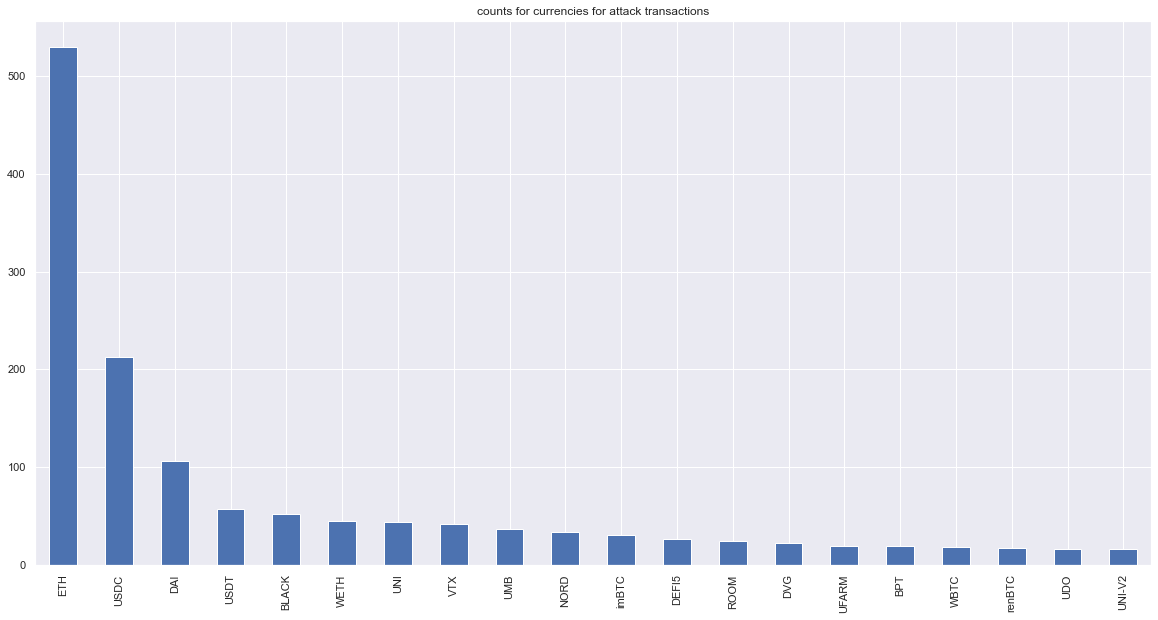

In [70]:
# How many times each hacker attacked
dsAttacksCurrency = dfData[dfData['Label'] == 1]['Currency'].value_counts()

print(f'Top {dsAttacksCurrency.shape[0]} currencies for attacks')
print(dsAttacksCurrency.head(len(dsAttacksCurrency))) #<! Last ones should be 1
dsAttacksCurrency[:20].plot(kind = 'bar',figsize = (20, 10), title = 'counts for currencies for attack transactions')

Top 2907 currencies for non-attacks
ETH      680880
WETH     192186
USDC     139820
USDT     118315
DAI       48547
          ...  
IDK           1
TOSHI         1
ELYX          1
BITS          1
LUFFY         1
Name: Currency, Length: 2907, dtype: int64


<AxesSubplot:title={'center':'counts for currencies for normal transactions'}>

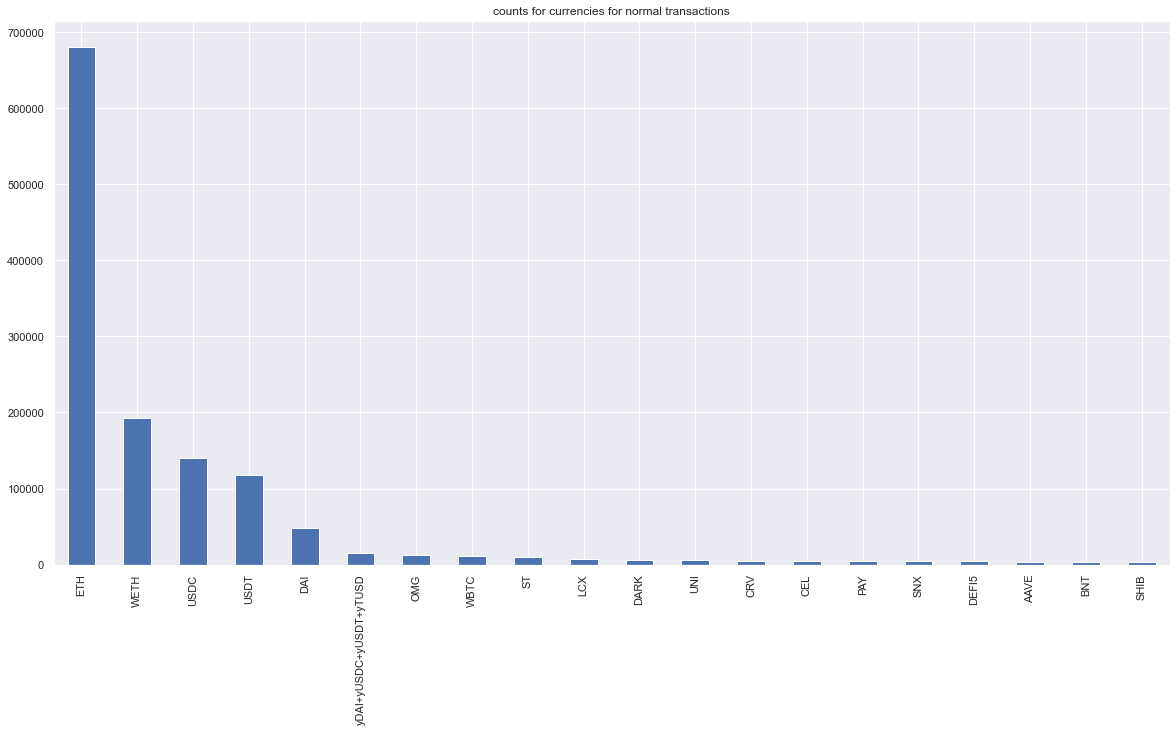

In [71]:
# How many times each hacker attacked
dsNonAttacksCurrency = dfData[dfData['Label'] == 0]['Currency'].value_counts()

print(f'Top {dsNonAttacksCurrency.shape[0]} currencies for non-attacks')
print(dsNonAttacksCurrency.head(len(dsNonAttacksCurrency))) #<! Last ones should be 1
dsNonAttacksCurrency[:20].plot(kind = 'bar',figsize = (20, 10), title = 'counts for currencies for normal transactions')

Top 3010 currencies 
ETH       681410
WETH      192231
USDC      140033
USDT      118372
DAI        48653
           ...  
ENTONE         1
LBurst         1
MXT            1
BRC            1
aTUSD          1
Name: Currency, Length: 3010, dtype: int64


<AxesSubplot:title={'center':'counts for currencies for all transactions'}>

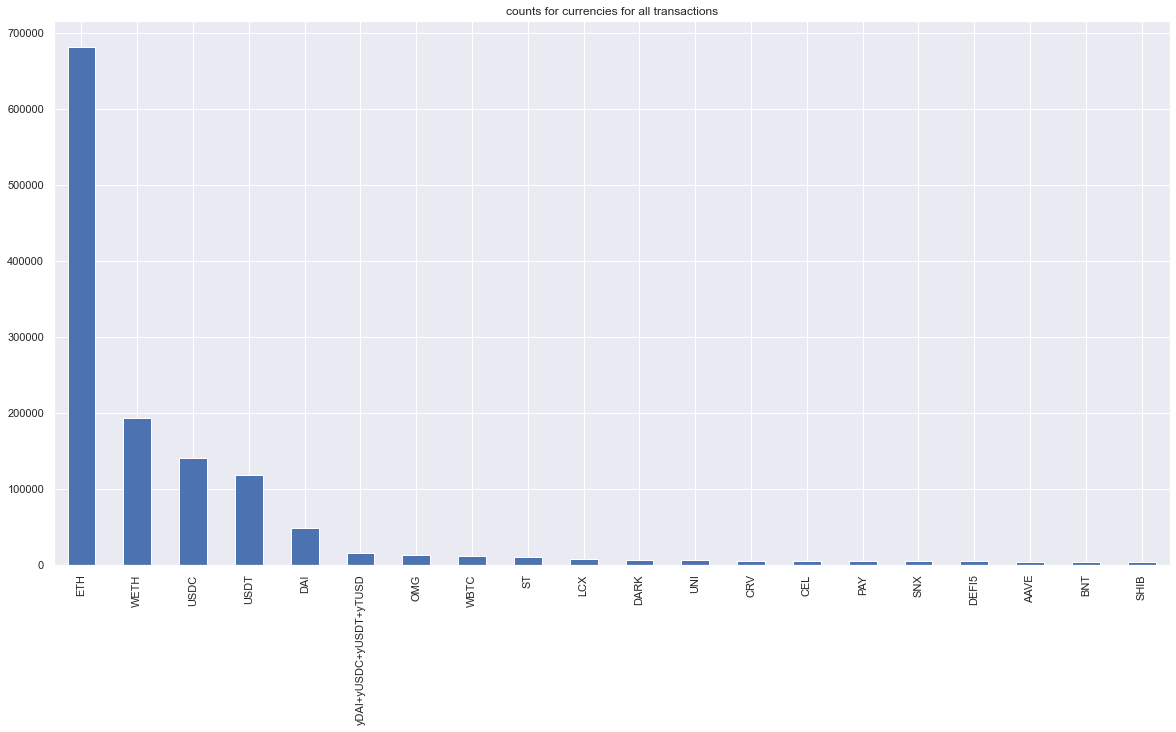

In [72]:
# How many times each hacker attacked
dsCurrency = dfData['Currency'].value_counts()

print(f'Top {dsCurrency.shape[0]} currencies ')
print(dsCurrency.head(len(dsCurrency))) #<! Last ones should be 1
dsCurrency[:20].plot(kind = 'bar',figsize = (20, 10), title = 'counts for currencies for all transactions')

### top 20 from the list

Top 15 currencies for attacks
USDC      213
DAI       106
USDT       57
WETH       45
UNI        44
WBTC       18
LINK       16
OMG        13
BAT         6
BNT         5
SHIB        4
MATIC       3
STRONG      2
HEX         2
LPT         1
Name: Currency, dtype: int64


<AxesSubplot:title={'center':'counts for top 20 currencies(from list) for attack transactions'}>

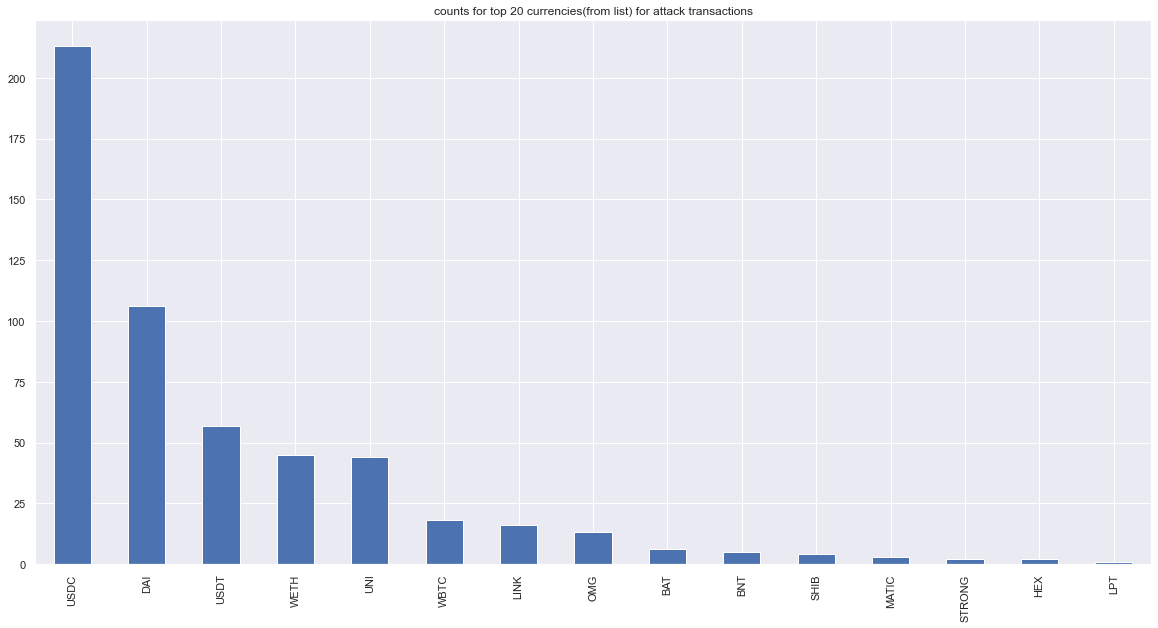

In [73]:
# How many times each hacker attacked
dsAttacksCurrency20 = dfData[(dfData['Label'] == 1) & (dfData['Currency'].isin(top_currs)) ]['Currency'].value_counts()

print(f'Top {dsAttacksCurrency20.shape[0]} currencies for attacks')
print(dsAttacksCurrency20.head(len(dsAttacksCurrency20))) #<! Last ones should be 1
dsAttacksCurrency20.plot(kind = 'bar',figsize = (20, 10), title = 'counts for top 20 currencies(from list) for attack transactions')

Top 17 currencies for non-attacks
WETH      192186
USDC      139820
USDT      118315
DAI        48547
OMG        13067
WBTC       11366
UNI         5380
BNT         3810
SHIB        3548
LINK        3535
MATIC       3017
BAT         2760
HEX         1668
STRONG       589
LPT          241
CARD          34
MGC            2
Name: Currency, dtype: int64


<AxesSubplot:title={'center':'counts for top 20 currencies for normal transactions'}>

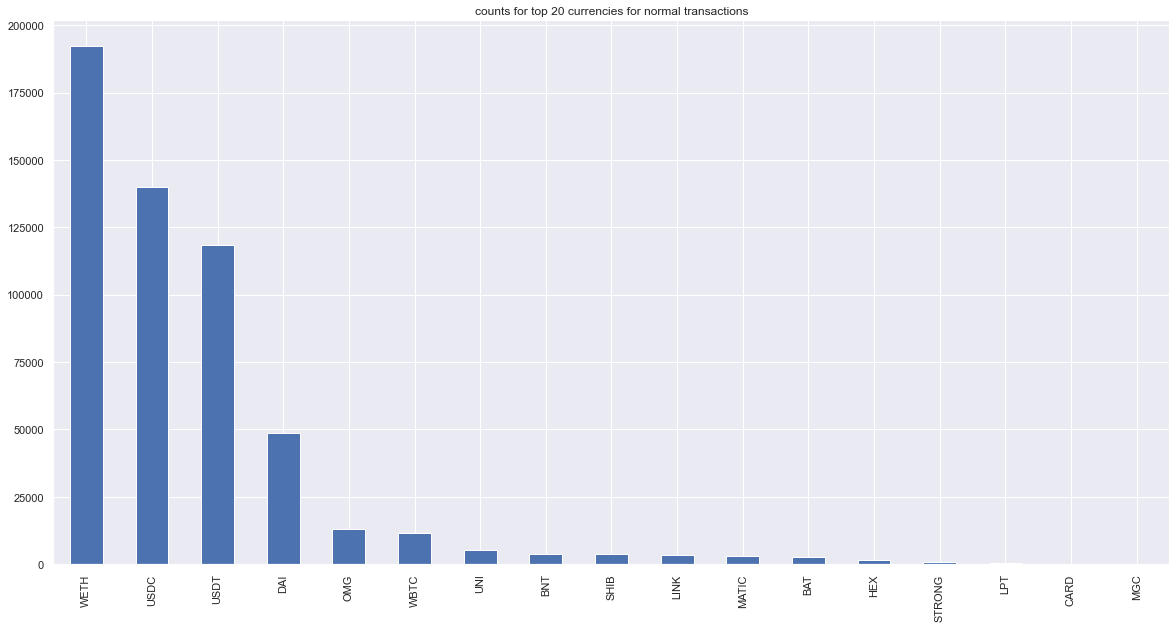

In [74]:
dsNonAttacksCurrency20 = dfData[(dfData['Label'] == 0) & (dfData['Currency'].isin(top_currs)) ]['Currency'].value_counts()

print(f'Top {dsNonAttacksCurrency20.shape[0]} currencies for non-attacks')
print(dsNonAttacksCurrency20.head(len(dsNonAttacksCurrency20))) #<! Last ones should be 1
dsNonAttacksCurrency20.plot(kind = 'bar',figsize = (20, 10), title = 'counts for top 20 currencies for normal transactions')

Top 17 currencies for all transaction
WETH      192231
USDC      140033
USDT      118372
DAI        48653
OMG        13080
WBTC       11384
UNI         5424
BNT         3815
SHIB        3552
LINK        3551
MATIC       3020
BAT         2766
HEX         1670
STRONG       591
LPT          242
CARD          34
MGC            2
Name: Currency, dtype: int64


<AxesSubplot:title={'center':'counts for top 20 currencies for all transactions'}>

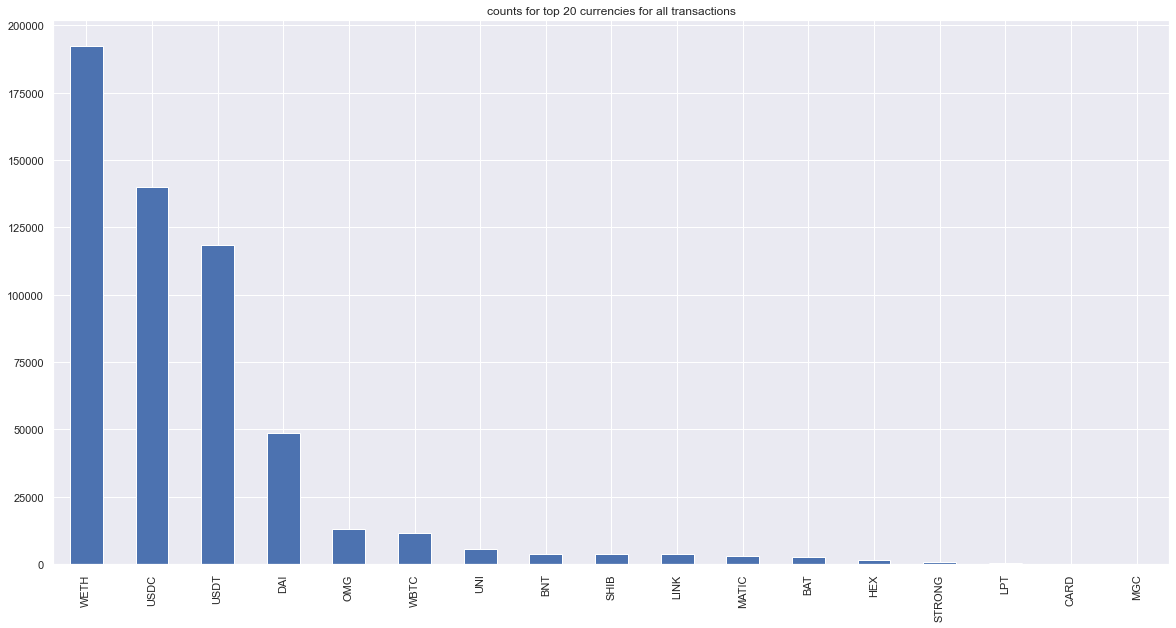

In [75]:
dsCurrency20 = dfData[dfData['Currency'].isin(top_currs) ]['Currency'].value_counts()

print(f'Top {dsCurrency20.shape[0]} currencies for all transaction')
print(dsCurrency20.head(len(dsCurrency20))) #<! Last ones should be 1
dsCurrency20.plot(kind = 'bar',figsize = (20, 10), title = 'counts for top 20 currencies for all transactions')